# Challenge 1 - Time Series Forecasting

The goal of the challenge was to forecast future points of time series belonging to six different categories.



## Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

## Load and process data

In [ ]:
dataset = np.load('training_data.npy').astype(np.float32)
categories = np.load('categories.npy')
valid_periods = np.load('valid_periods.npy')
print(dataset.shape)
print(categories.shape)
print(valid_periods.shape)

(48000, 2776)
(48000,)
(48000, 2)


### Visualize data

In [ ]:
df_dataset = pd.DataFrame(dataset)
df_periods = pd.DataFrame(valid_periods)

df_dataset.info()
df_periods.info()

In [ ]:
# Check if there are outliers in the categories

cat = ['A', 'B', 'C', 'D', 'E', 'F']

for i in range(0, len(categories)):
  if(categories[i] not in cat):
    print(categories[i])

2725 2776


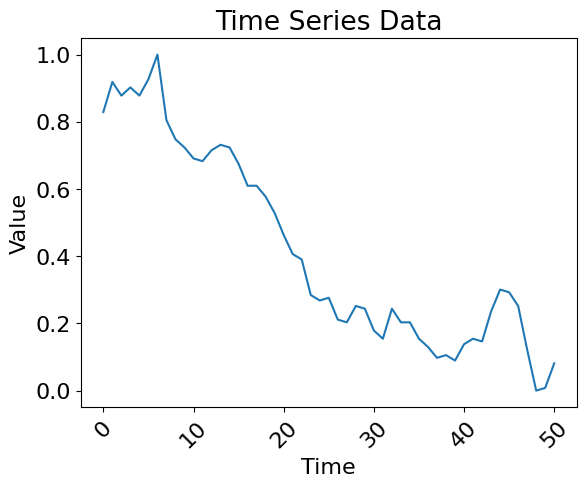

In [ ]:
# Print randomly one of the time series in the dataset

row_cleaned = []
idx = random.randint(0, 48000)

row = dataset[idx]
print(valid_periods[idx][0], valid_periods[idx][1])

for i in range(valid_periods[idx][0], valid_periods[idx][1]):
  row_cleaned.append(row[i])


plt.plot(row_cleaned)
plt.xlabel('Time')
plt.ylabel('Value')
plt.xticks(rotation = 45)
plt.title('Time Series Data')
plt.show()


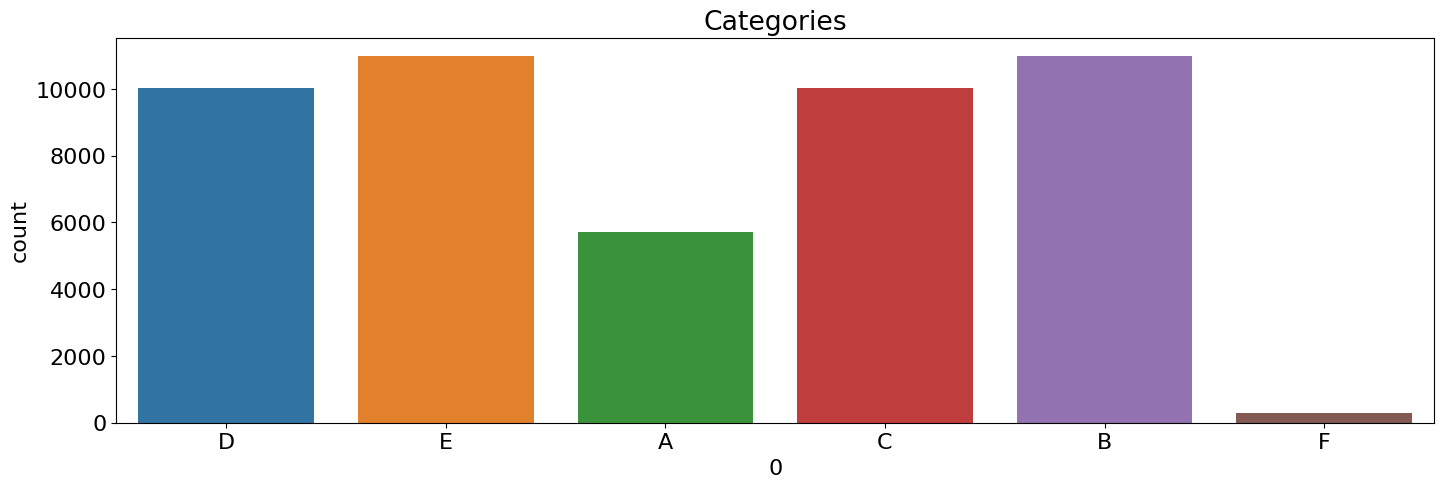

In [ ]:
# Show the dataset distribution among categories

df = pd.DataFrame(categories)

plt.figure(figsize=(17,5))
sns.countplot(data = df, x=0)
plt.title('Categories')
plt.show()

### Statistics from the dataset

The following code helped us understand the differences in length of the various categories.

In [ ]:
min = 2776

for i in range(0, len(valid_periods)):
  tmp = valid_periods[i][1] - valid_periods[i][0]
  if tmp < min:
    min = tmp
    idx = i
    label = categories[i]

print("min: ", min)
print("label: ", label)
print("index: ", idx)


min:  24
label:  F
index:  47852


In [ ]:
max = 0

for i in range(0, len(valid_periods)):
  tmp = valid_periods[i][1] - valid_periods[i][0]
  if tmp > max:
    max = tmp
    idx = i
    label = categories[i]

print("max: ", max)
print("label: ", label)
print("index: ", idx)

max:  2776
label:  E
index:  17143


In [ ]:
sum_categories = [0, 0, 0, 0, 0, 0]
occurrencies = [0, 0, 0, 0, 0, 0]

for i in range(0, len(valid_periods)):
  tmp = valid_periods[i][1] - valid_periods[i][0]

  sum_categories[cat.index(categories[i])] += tmp
  occurrencies[cat.index(categories[i])] = occurrencies[cat.index(categories[i])]+1

for i in range(0, len(cat)):
  print("Average lenght", cat[i], sum_categories[i]/occurrencies[i])


Average lenght A 278.18034217877096
Average lenght B 165.9428415400018
Average lenght C 208.14625137266646
Average lenght D 216.9909145367412
Average lenght E 163.04601366742597
Average lenght F 194.8303249097473


### Clean Dataset

We decided to remove the padding from the dataset to consider only the valid part of each time series.

In [ ]:
cleaned_dataset = []

for i in range(0, len(dataset)):
  row = []
  for j in range(valid_periods[i][0], valid_periods[i][1]):
    row.append(dataset[i][j])

  row = np.array(row)
  cleaned_dataset.append(row)

In [ ]:
cleaned_dataset = np.array(cleaned_dataset)
cleaned_dataset.shape
np.save('cleaned_dataset.npy', cleaned_dataset)

(48000,)

In [ ]:
# Load the cleaned dataset from the storage
cleaned_dataset = np.load('cleaned_dataset.npy', allow_pickle=True)
cleaned_dataset.shape

(48000,)

## Split Dataset

We decided to split the dataset only in train and validation to have more data available for the training phase. We splitted the dataset maintaining the proportionality between the categories.

In [ ]:
X_train_raw, X_val_raw, y_train_raw, y_val_raw = train_test_split(cleaned_dataset, categories, test_size=0.1, stratify=categories)

print("X_train: ", X_train_raw.shape)
print("X_val: ", X_val_raw.shape)

X_train:  (43200,)
X_val:  (4800,)


### Visualization
Code used to visualize the number of samples in each category for train and validation sets.

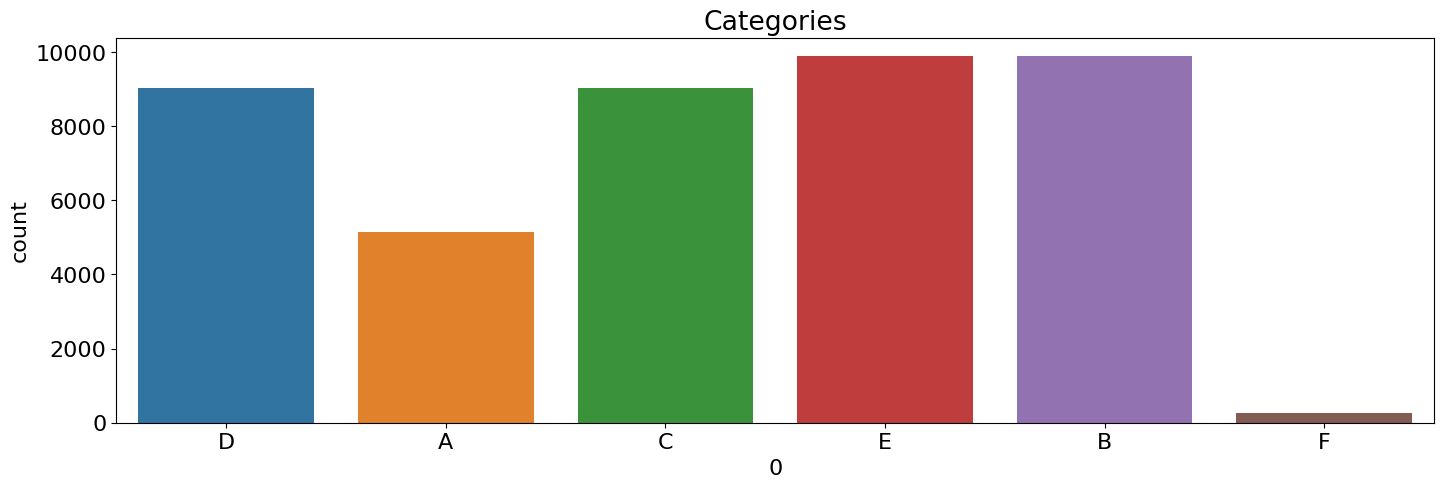

In [ ]:
df = pd.DataFrame(y_train_raw)

plt.figure(figsize=(17,5))
sns.countplot(data = df, x=0)
plt.title('Categories')
plt.show()

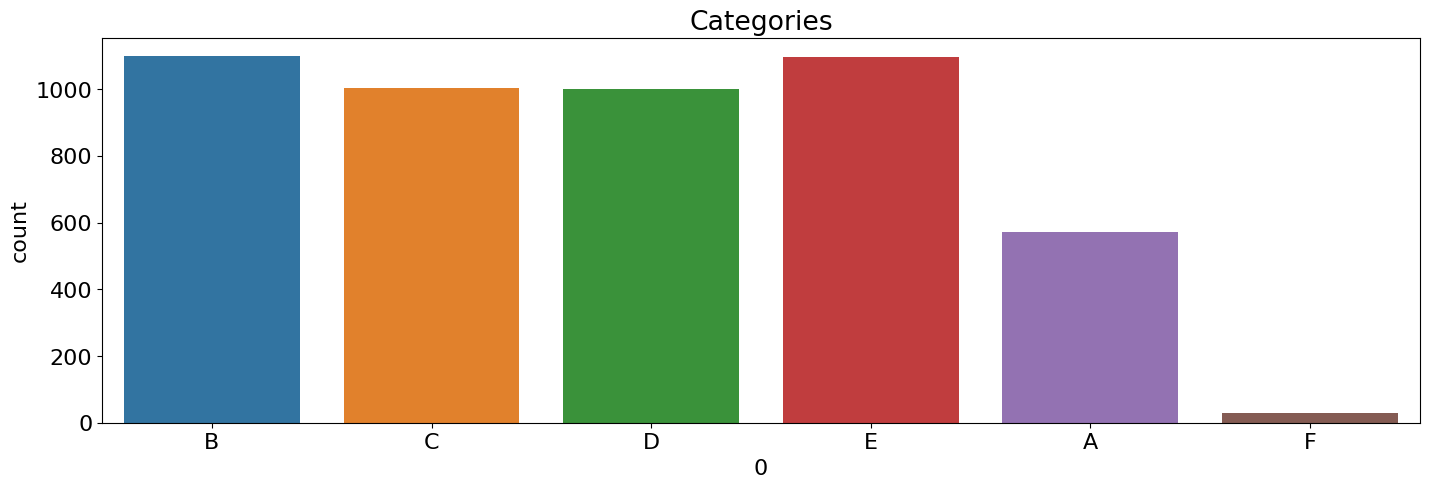

In [ ]:
df = pd.DataFrame(y_val_raw)

plt.figure(figsize=(17,5))
sns.countplot(data = df, x=0)
plt.title('Categories')
plt.show()

### Split by categories

We also used a variation of the original dataset split to create an ensable model where each model in it was trained on a specific category. This is the code to have a train and val set made only by the selected category.

In [ ]:
selected_categories = ['A']

selected_data = []
cat = []

for i in range(0, len(categories)):
  if(categories[i] in selected_categories):
    selected_data.append(cleaned_dataset[i])
    cat.append(categories[i])

selected_data = np.array(selected_data)

X_train_raw, X_val_raw, y_train_raw, y_val_raw = train_test_split(selected_data, cat, test_size=0.1)

print("X_train: ", X_train_raw.shape)
print("X_val: ", X_val_raw.shape)

X_train:  (5155,)
X_val:  (573,)


### Build sequences, finalize train and val set

We initially trained with every sequence that was possible to create and later on tried to discard sequences that had a padding grater than max_padding, but this didn't increase our accuracy.

In [ ]:
def build_sequences(df, window=200, stride=20, telescope=18, max_padding=200):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []

    for i in range(0, len(df)):
      row = df[i]
      padding_check = len(row)%window

      # Add the necessary padding to build the sequence
      if(padding_check != 0):
        padding_len = window - len(row)%window + telescope  # In this way we have the correct dimension to create at least one sequence for each time series in the dataset
        padding = np.zeros(padding_len, dtype='float32')
        row = np.concatenate((padding,row))

      # Append the sequences to the dataset
      for idx in np.arange(0,len(row)-window-telescope+1,stride):
        #if(not np.all(row[idx:idx+window] == 0)):
        if(window - np.count_nonzero(row[idx:idx+window]) <= max_padding):
          dataset.append(row[idx:idx+window])
          labels.append(row[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

These are the standard values that we have used in most of our trainings, but we experimented also with a stride of 40 that in one case improved the accuracy and also with smaller stride.
The telescope used was always 18 to avoid retraining the model between Phase 1 (where only the first 9 values are required) and Phase 2

In [ ]:
window = 200
stride = 20
direct_telescope = 18
max_padding = 200

X_train, y_train = build_sequences(X_train_raw, window, stride, direct_telescope, max_padding)
X_val, y_val = build_sequences(X_val_raw, window, stride, direct_telescope, max_padding)
print('Train shape: ', X_train.shape)
print('Train label shape: ', y_train.shape)
print('Val shape: ', X_val.shape)
print('Val label shape: ', y_val.shape)

Train shape:  (281214, 200)
Train label shape:  (281214, 18)
Val shape:  (31611, 200)
Val label shape:  (31611, 18)


In [ ]:
# Some model that we tried don't need this reshape
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)
print('Train shape: ', X_train.shape)
print('Train label shape: ', y_train.shape)
print('Val shape: ', X_val.shape)
print('Val label shape: ', y_val.shape)

Train shape:  (281214, 200, 1)
Train label shape:  (281214, 18, 1)
Val shape:  (31611, 200, 1)
Val label shape:  (31611, 18, 1)


## Models

This is the collection of models that we tried for this challenge.
In order, these were the three best performing:

*   2 Bidirectional LSTM with Conv1D between
*   Encoder-Decoder
*   ResNet like



### Bidirectional LSTM + Conv1D

We started from the architecture that we have seen during the laboratory.

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 1024
epochs = 200
print('Input shape: ', input_shape)
print('Output shape: ', output_shape)

Input shape:  (200, 1)
Output shape:  (18, 1)


In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 bidirectional_lstm (Bidire  (None, 200, 128)          33792     
 ctional)                                                        
                                                                 
 conv (Conv1D)               (None, 200, 128)          49280     
                                                                 
 output_layer (Conv1D)       (None, 200, 1)            385       
                                                                 
 cropping (Cropping1D)       (None, 18, 1)             0         
                                                                 
Total params: 83457 (326.00 KB)
Trainable params: 83457 (326.00 KB)
Non-trainable params: 0 (0.00 Byte)
_____________

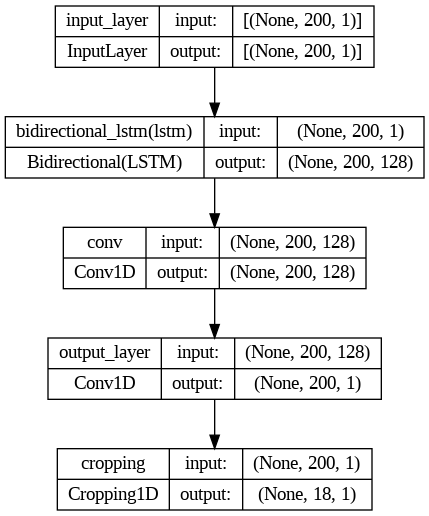

In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

### Conv1D + Bidirectional LSTM

Here we inverted the previous model to see which of the two was performing better.


In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 1024
epochs = 200
print('Input shape: ', input_shape)
print('Output shape: ', output_shape)

Input shape:  (200, 1)
Output shape:  (18, 1)


In [ ]:
def build_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0]

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.Conv1D(64, 13, padding='same', activation='relu', name='conv1')(input_layer)
    x = tfkl.BatchNormalization()(x)

    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv2')(x)
    x = tfkl.BatchNormalization()(x)

    x = tfkl.MaxPool1D()(x)
    x = tfkl.BatchNormalization()(x)

    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='LSTM'))(x)
    x = tfkl.BatchNormalization()(x)

    x = tfkl.GlobalAveragePooling1D()(x)
    x = tfkl.Dropout(.3)(x)

    x = tfkl.Dense(output_shape[-1] * output_shape[-2], activation='relu')(x)
    output_layer = tfkl.Reshape((output_shape[-2], output_shape[-1]))(x)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)


    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='Conv_LSTM_model')
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(), metrics=['mae'])

    return model

Model: "Conv_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 200, 1)]          0         
                                                                 
 conv1 (Conv1D)              (None, 200, 64)           896       
                                                                 
 batch_normalization (Batch  (None, 200, 64)           256       
 Normalization)                                                  
                                                                 
 conv2 (Conv1D)              (None, 200, 128)          24704     
                                                                 
 batch_normalization_1 (Bat  (None, 200, 128)          512       
 chNormalization)                                                
                                                                 
 max_pooling1d (MaxPooling1  (None, 100, 128)      

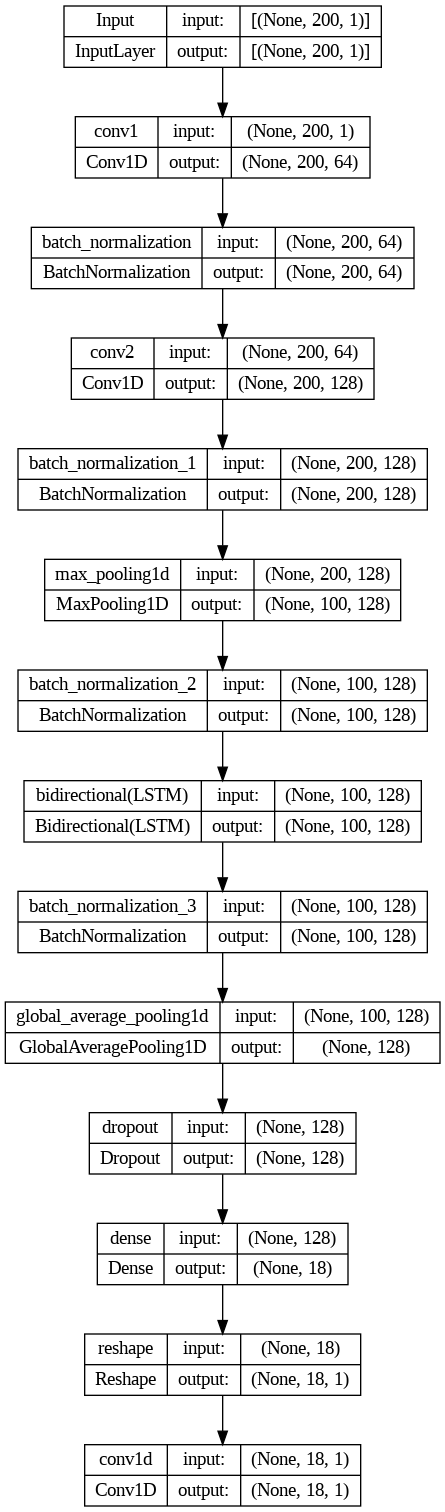

In [ ]:
model = build_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

###  2 Bidirectional LSTM with Conv1D between

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 1024
epochs = 200
print('Input shape: ', input_shape)
print('Output shape: ', output_shape)

Input shape:  (200, 1)
Output shape:  (18, 1)


In [ ]:
def build_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0]

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True, name='LSTM'))(input_layer)
    x = tfkl.BatchNormalization()(x)

    x = tfkl.Conv1D(64, 13, padding='same', activation='relu', name='conv1')(x)
    x = tfkl.BatchNormalization()(x)

    x = tfkl.MaxPool1D()(x)
    x = tfkl.BatchNormalization()(x)

    x = tfkl.Conv1D(64, 13, padding='same', activation='relu', name='conv2')(x)
    x = tfkl.BatchNormalization()(x)

    x = tfkl.MaxPool1D()(x)
    x = tfkl.BatchNormalization()(x)

    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv3')(x)
    x = tfkl.BatchNormalization()(x)

    x = tfkl.MaxPool1D()(x)
    x = tfkl.BatchNormalization()(x)

    x = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True, name='LSTM'))(x)
    x = tfkl.BatchNormalization()(x)

    x = tfkl.GlobalAveragePooling1D()(x)
    x = tfkl.Dropout(.3)(x)

    output_layer = tfkl.Dense(output_shape[-1] * output_shape[-2], activation='relu')(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='Conv_LSTM_model')
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(), metrics=['mae'])

    return model

Model: "Conv_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 200, 1)]          0         
                                                                 
 bidirectional_10 (Bidirect  (None, 200, 128)          33792     
 ional)                                                          
                                                                 
 batch_normalization_25 (Ba  (None, 200, 128)          512       
 tchNormalization)                                               
                                                                 
 conv1 (Conv1D)              (None, 200, 64)           106560    
                                                                 
 batch_normalization_26 (Ba  (None, 200, 64)           256       
 tchNormalization)                                               
                                                   

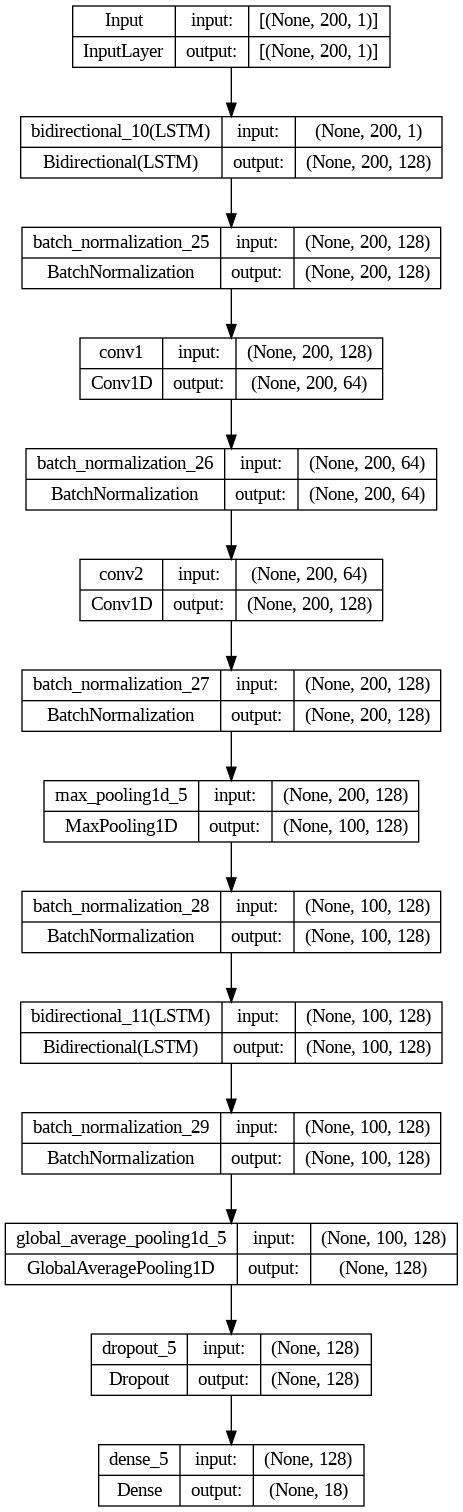

In [ ]:
model = build_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

### Ensemble

Here we created trained a separated model for each category. The base model we used is the one mentioned above trained with the function to separate the dataset for each category.

The code below is the one inserted in the model.py

In [ ]:
import os
import tensorflow as tf
import numpy as np

class model:
    def __init__(self, path):
        self.modelA = tf.keras.models.load_model(os.path.join(path, 'SubmissionModelA'))
        self.modelB = tf.keras.models.load_model(os.path.join(path, 'SubmissionModelB'))
        self.modelC = tf.keras.models.load_model(os.path.join(path, 'SubmissionModelC'))
        self.modelD = tf.keras.models.load_model(os.path.join(path, 'SubmissionModelD'))
        self.modelE = tf.keras.models.load_model(os.path.join(path, 'SubmissionModelE'))
        self.modelF = tf.keras.models.load_model(os.path.join(path, 'SubmissionModelF'))

    def predict(self, X, categories):

        out = []

        for x, category in zip(X, categories):
            x = np.expand_dims(x, axis=0)

            if category == 'A':
                pred = self.modelA.predict(x)
            elif category == 'B':
                pred = self.modelB.predict(x)
            elif category == 'C':
                pred = self.modelC.predict(x)
            elif category == 'D':
                pred = self.modelD.predict(x)
            elif category == 'E':
                pred = self.modelE.predict(x)
            elif category == 'F':
                pred = self.modelF.predict(x)

            out.append(pred)

        out = np.array(out)
        out = np.squeeze(out, 1)


### Encoder - Decoder -- Version 1

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 1024
epochs = 200
print('Input shape: ', input_shape)
print('Output shape: ', output_shape)

Input shape:  (200, 1)
Output shape:  (18, 1)


In [ ]:
def get_encoder(enc_input_shape):

  x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv1')(enc_input_shape)
  x = tfkl.BatchNormalization()(x)
  x = tfkl.MaxPooling1D()(x)

  x = tfkl.Conv1D(64, 13, padding='same', activation='relu', name='conv2')(x)
  x = tfkl.BatchNormalization()(x)
  x = tfkl.MaxPooling1D()(x)

  x = tfkl.Flatten()(x)

  output_layer=tfkl.Dense(x.shape[-1],name='output_layer', activation='relu')(x)

  return output_layer

In [ ]:
def get_decoder(dec_input_shape):

  x = tfkl.Dense(dec_input_shape.shape[-1], activation='relu', name = "dense2")(dec_input_shape)
  x = tfkl.BatchNormalization()(x)

  #invert the flattening by reshaping
  x = tfkl.Reshape((int(x.shape[-1]/64),64))(x)

  #up-sampling block
  x = tfkl.UpSampling1D()(x)
  x = tfkl.Conv1D(64, 13, padding='same', activation='relu', name='conv3')(x)
  x = tfkl.BatchNormalization()(x)

  x = tfkl.UpSampling1D()(x)
  x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv4')(x)
  x  = tfkl.BatchNormalization()(x)


  output_layer = tfkl.Conv1D(128,3, padding='same', activation='relu', name='conv5')(x)

  return output_layer

In [ ]:
def build_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0]

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='LSTM'))(input_layer)
    x = tfkl.BatchNormalization()(x)

    x = get_encoder(x)
    x = get_decoder(x)

    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='LSTM'))(x)
    x = tfkl.BatchNormalization()(x)

    x = tfkl.GlobalAveragePooling1D()(x)
    x = tfkl.Dropout(.3)(x)

    output_layer = tfkl.Dense(output_shape[-1] * output_shape[-2], activation='linear', name = "dense3")(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='Autoencoder_model')
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(), metrics=['mae'])

    return model

(None, 50, 64)
(None, 50, 64)
(None, 200, 128)
(None, 200, 128)
(None, 200, 128)
(None, 128)
Model: "Conv_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 200, 1)]          0         
                                                                 
 bidirectional (Bidirection  (None, 200, 128)          33792     
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, 200, 128)          512       
 Normalization)                                                  
                                                                 
 conv1 (Conv1D)              (None, 200, 128)          49280     
                                                                 
 batch_normalization_1 (Bat  (None, 200, 128)          512       
 chNormalization)       

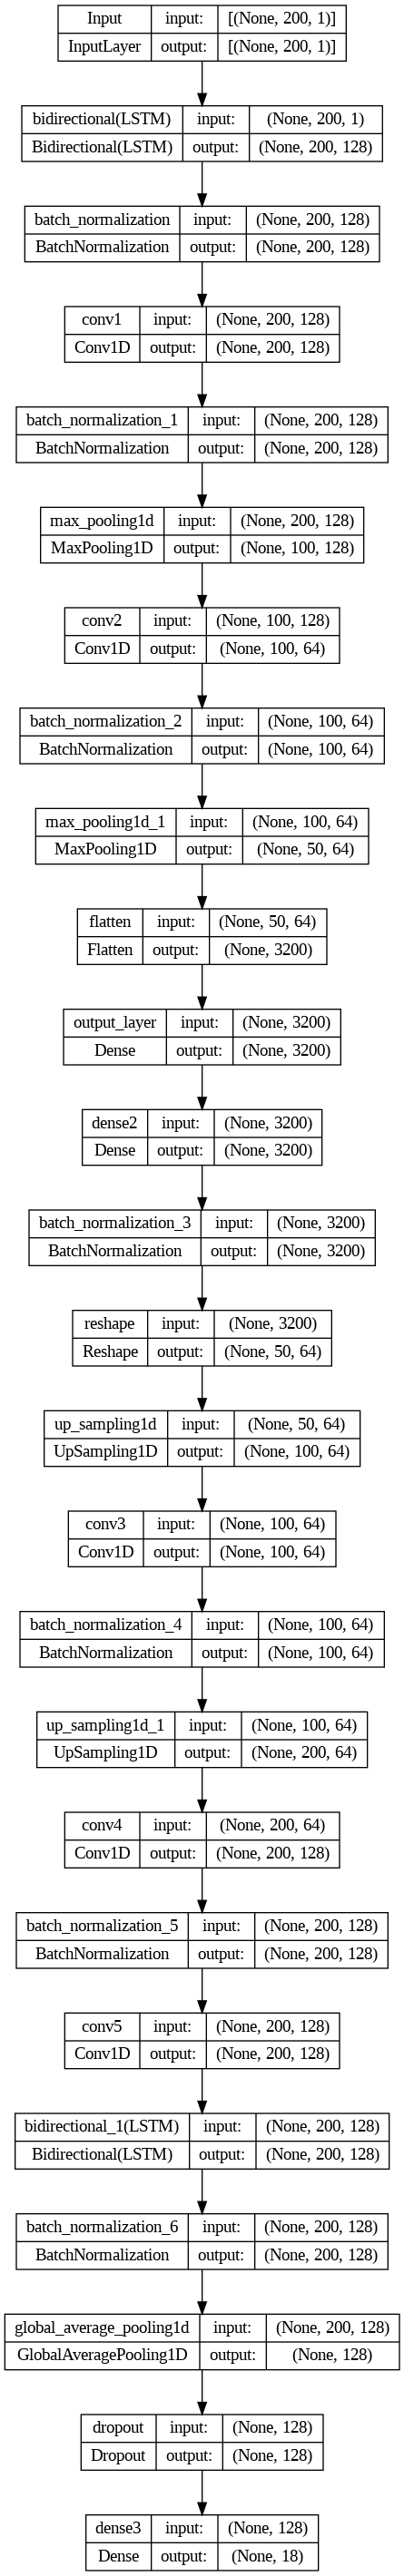

In [ ]:
model = build_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

### Encoder - Decoder -- Version 2

Differently from the previous model, other than the internal structure changes it is also added an attention layer.

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 1024
epochs = 200
print('Input shape: ', input_shape)
print('Output shape: ', output_shape)

Input shape:  (200, 1)
Output shape:  (18, 1)


In [ ]:
def build_model(input_shape, output_shape):
    # Build Encoder-Decoder Model

    # ENCODER
    encoder_inputs = tfkl.Input(shape=input_shape, name='encoder_input')
    encoder_output = tfkl.Bidirectional(tfkl.LSTM(units=64, return_state=True, return_sequences=True, name='encoder_lstm'))(encoder_inputs)

    # Save encoder state (to initialize the decoder)
    encoder_state = encoder_output[1:]

    # DECODER
    decoder_inputs = tfkl.Input(shape=input_shape, name='decoder_input')
    decoder_lstm, _, _, *_ = tfkl.Bidirectional(tfkl.LSTM(units=64, return_sequences=True, return_state=True, name='decoder_lstm'))(decoder_inputs, initial_state=encoder_state)

    attention_layer = tfkl.Attention()([decoder_lstm, encoder_output[0]])

    # Concatenate attention output and decoder LSTM output
    decoder_concat = tfkl.Concatenate(axis=-1)([decoder_lstm, attention_layer])
    decoder_gap = tfkl.GlobalAveragePooling1D()(decoder_concat)
    decoder_out = tfkl.Dense(output_shape[-1] * output_shape[-2])(decoder_gap)

    # MODEL
    model = tf.keras.Model([encoder_inputs, decoder_inputs],  decoder_out)
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(), metrics=['mae'])

    return model

In [ ]:
model = build_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = [X_train, X_train],
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=([X_val, X_val], y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

### Encoder - Decoder -- Version 3

The structure is the same as the Version 1, apart from removing the flattening layer from the encoder, but now it is also added an attention layer that goes from the encoder to the decoder. Unfortunately this adding didn't improve our accuracy.

In [ ]:
def get_encoder(enc_input_shape):

  #block of conv + batch normalization
  x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv1')(enc_input_shape)
  x = tfkl.BatchNormalization()(x)
  x = tfkl.MaxPooling1D()(x)

  x = tfkl.Conv1D(64, 13, padding='same', activation='relu', name='conv2')(x)
  x = tfkl.BatchNormalization()(x)
  output_layer = tfkl.MaxPooling1D()(x)

  return output_layer

In [ ]:
def get_decoder(dec_input_shape):

  x = tfkl.Dense(dec_input_shape.shape[-1], activation='relu', name = "dense2")(dec_input_shape)
  x = tfkl.BatchNormalization()(x)

  x = tfkl.UpSampling1D()(x)
  x = tfkl.Conv1D(64, 13, padding='same', activation='relu', name='conv3')(x)
  x = tfkl.BatchNormalization()(x)

  x = tfkl.UpSampling1D()(x)
  x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv4')(x)
  x  = tfkl.BatchNormalization()(x)


  output_layer = tfkl.Conv1D(128,3, padding='same', activation='relu', name='conv5')(x)

  return output_layer

In [ ]:
def build_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0]

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    encoder_lstm = tfkl.Bidirectional(tfkl.LSTM(64, return_state=True, return_sequences=True, name='LSTM'))(input_layer)

    x = get_encoder(encoder_lstm[0])
    x = get_decoder(x)

    decoder_lstm, _, _, *_ = tfkl.Bidirectional(tfkl.LSTM(units=64, return_sequences=True, return_state=True, name='decoder_lstm'))(x)

    attention_layer = tfkl.Attention()([decoder_lstm, encoder_lstm[0]])
    decoder_concat = tfkl.Concatenate(axis=-1)([decoder_lstm, attention_layer])

    x = tfkl.BatchNormalization()(decoder_concat)

    x = tfkl.GlobalAveragePooling1D()(x)
    x = tfkl.Dropout(.3)(x)

    output_layer = tfkl.Dense(output_shape[-1] * output_shape[-2], activation='linear', name = "dense3")(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='Conv_LSTM_model')
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(), metrics=['mae'])

    return model

In [ ]:
model = build_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

### ResNet like architecture

This model was inspired by the ResNet architecture, where there are "shortcuts" in the model to help it understand better.
We tried different combination of n_filter, kernel sizes and number of blocks, but this one was the best performing. <br>

We also tried to add attention to this model but also this doesn't improved our result.

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 1024
epochs = 200
print('Input shape: ', input_shape)
print('Output shape: ', output_shape)

Input shape:  (200, 1)
Output shape:  (18, 1)


In [ ]:
def build_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0]

    n_filter = 64
    dropout_rate = 0.3

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True, name='LSTM'))(input_layer)
    block_0 = tfkl.BatchNormalization()(x)

    # BLOCK 1
    x = tfkl.Conv1D(n_filter , 13, padding='same', activation='relu', name='conv1')(block_0)
    x = tfkl.Dropout(dropout_rate)(x)
    x = tfkl.BatchNormalization()(x)

    x = tfkl.Conv1D(n_filter , 8, padding='same', activation='relu', name='conv2')(x)
    x = tfkl.Dropout(dropout_rate)(x)
    x = tfkl.BatchNormalization()(x)

    x = tfkl.Conv1D(n_filter , 5, padding='same', activation='relu', name='conv3')(x)
    x = tfkl.Dropout(dropout_rate)(x)
    x = tfkl.BatchNormalization()(x)

    x = tfkl.Conv1D(n_filter , 3, padding='same', activation='relu', name='conv4')(x)
    x = tfkl.Dropout(dropout_rate)(x)
    x = tfkl.BatchNormalization()(x)

    block_0 = tfkl.Conv1D(n_filter , 1, padding='same', activation='relu', name='conv5')(block_0)
    x = tfkl.add([block_0, x])
    x = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True, name='LSTM'))(x)
    block_1 = tfkl.BatchNormalization()(x)

    # BLOCK 2
    x = tfkl.Conv1D(n_filter * 2, 13, padding='same', activation='relu', name='conv6')(block_1)
    x = tfkl.Dropout(dropout_rate)(x)
    x = tfkl.BatchNormalization()(x)

    x = tfkl.Conv1D(n_filter * 2, 8, padding='same', activation='relu', name='conv7')(x)
    x = tfkl.Dropout(dropout_rate)(x)
    x = tfkl.BatchNormalization()(x)

    x = tfkl.Conv1D(n_filter * 2, 5, padding='same', activation='relu', name='conv8')(x)
    x = tfkl.Dropout(dropout_rate)(x)
    x = tfkl.BatchNormalization()(x)

    x = tfkl.Conv1D(n_filter * 2, 3, padding='same', activation='relu', name='conv9')(x)
    x = tfkl.Dropout(dropout_rate)(x)
    x = tfkl.BatchNormalization()(x)

    block_1 = tfkl.Conv1D(n_filter * 2, 1, padding='same', activation='relu', name='conv10')(block_1)
    x = tfkl.add([block_1, x])
    x = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True, name='LSTM'))(x)
    block_2 = tfkl.BatchNormalization()(x)

    x = tfkl.GlobalAveragePooling1D()(block_2)
    x = tfkl.Dropout(.3)(x)

    output_layer = tfkl.Dense(output_shape[-1] * output_shape[-2], activation='relu', name = "dense3")(x)


    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='Conv_LSTM_model')
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(), metrics=['mae'])

    return model

Model: "Conv_LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 200, 1)]             0         []                            
                                                                                                  
 bidirectional_3 (Bidirecti  (None, 200, 128)             33792     ['Input[0][0]']               
 onal)                                                                                            
                                                                                                  
 batch_normalization_9 (Bat  (None, 200, 128)             512       ['bidirectional_3[0][0]']     
 chNormalization)                                                                                 
                                                                                    

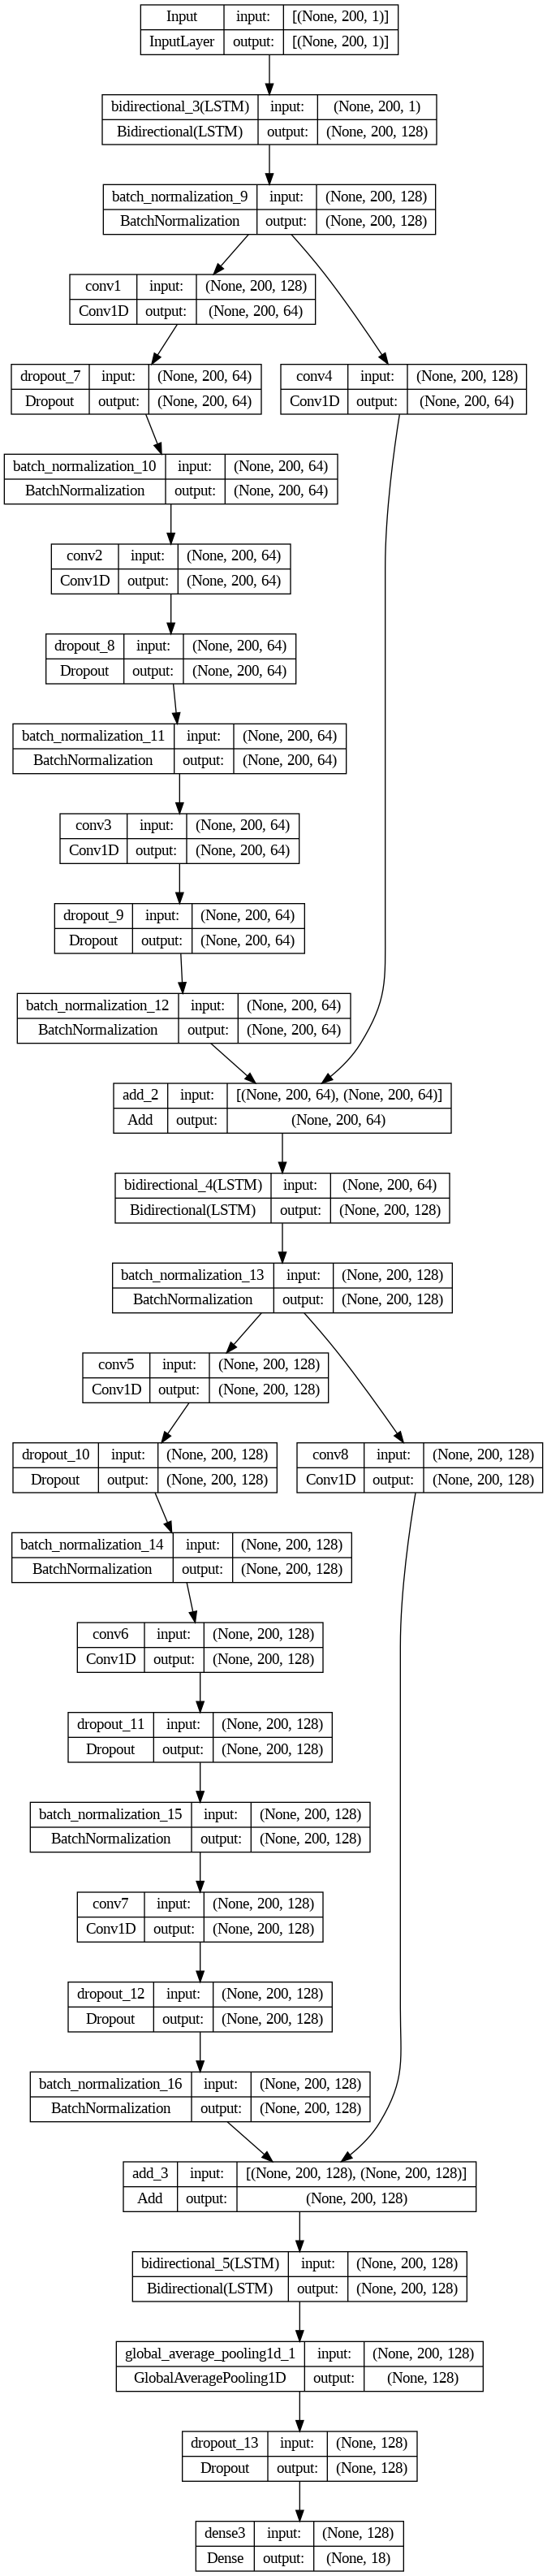

In [ ]:
model = build_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

### Linear

Given the recent discoveries where linear models were outperforming more complex models on the time series forecasting task, we tried several linear architecture, with 0 or more hidden layers, hoping to reproduce their results. Unfortunately this was not the case and they didn't improve our score.

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200
print('Input shape: ', input_shape)
print('Output shape: ', output_shape)

In [ ]:
def build_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0]

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    #x = tfkl.Dense(128, activation='linear', kernel_initializer='he_uniform')(input_layer)

    output_layer = tfkl.Dense(units=output_shape[-1], activation='linear', kernel_initializer='he_uniform')(input_layer)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='FC')

    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(), metrics=['mae'])

    return model

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

### Time2Vec BiLSTM

Here we added an encoding of the time series based on the idea of "word2vec".

In [ ]:
class Time2Vec(tfkl.Layer):

    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(Time2Vec, self).__init__(**kwargs)

    def build(self, input_shape):

        self.W = self.add_weight(name='W',
                                shape=(input_shape[-1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.P = self.add_weight(name='P',
                                shape=(input_shape[1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.w = self.add_weight(name='w',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        self.p = self.add_weight(name='p',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        super(Time2Vec, self).build(input_shape)

    def call(self, x):

        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)

        return K.concatenate([sin_trans, original], -1)

In [ ]:
def build_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0]

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = Time2Vec(16)(input_layer)
    x = tfkl.Bidirectional(tfkl.LSTM(64, activation='relu', return_sequences = True))(x)

    x = tfkl.GlobalAveragePooling1D()(x)

    output_layer = tfkl.Dense(output_shape[-1] * output_shape[-2], activation='linear', name = "dense3")(x)


    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='Time2Vec_model')
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(), metrics=['mae'])

    return model

In [ ]:
model = build_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

### Transformer

This is a basic variant of the transformer where it's used only the encoder part and the time series are embedded using the Time2Vec function that we have seen before.

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 1024
epochs = 200
print('Input shape: ', input_shape)
print('Output shape: ', output_shape)

In [ ]:
class Time2Vec(tfkl.Layer):

    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(Time2Vec, self).__init__(**kwargs)

    def build(self, input_shape):

        self.W = self.add_weight(name='W',
                                shape=(input_shape[-1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.P = self.add_weight(name='P',
                                shape=(input_shape[1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.w = self.add_weight(name='w',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        self.p = self.add_weight(name='p',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        super(Time2Vec, self).build(input_shape)

    def call(self, x):

        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)

        return K.concatenate([sin_trans, original], -1)

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = tfkl.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = tfkl.Dropout(dropout)(x)
    x = tfkl.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = tfkl.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = tfkl.Dropout(dropout)(x)
    x = tfkl.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = tfkl.LayerNormalization(epsilon=1e-6)(x)
    return x + res



def build_model(input_shape, output_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):

    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    x = input_layer
    x = Time2Vec(128)(x)
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = tfkl.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = tfkl.Dense(dim, activation="relu")(x)
        x = tfkl.Dropout(mlp_dropout)(x)

    output_layer = tfkl.Dense(output_shape[0], activation="linear")(x)


    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='Transformer_model')
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(), metrics=['mae'])

    return model

In [ ]:
model = build_model(
    input_shape,
    output_shape,
    head_size=128,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=1,
    mlp_units=[512],
    mlp_dropout=0.3,
    dropout=0.25,
)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

### N-BEATS

We tried also this model that was the state-of-art for time series forecasting in 2020. We used a slightly lighter version of the one mentioned in the paper due to resource constraints.

In [ ]:
# Create NBeatsBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               dropout_rate: float,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers
    self.dropout_rate = dropout_rate

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.dropout_layers = [tf.keras.layers.Dropout(self.dropout_rate) for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called
    x = inputs
    for layer, dropout_layer in zip(self.hidden, self.dropout_layers):  # Apply dropout after each dense layer
        x = layer(x)
        x = dropout_layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [ ]:
HORIZON = 18
WINDOW_SIZE = 200
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 8
DROPOUT_RATE = 0.3

INPUT_SIZE = WINDOW_SIZE
THETA_SIZE = INPUT_SIZE + HORIZON

In [ ]:
def build_model():
    nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                     theta_size=THETA_SIZE,
                                     horizon=HORIZON,
                                     n_neurons=N_NEURONS,
                                     n_layers=N_LAYERS,
                                     name="InitialBlock",
                                     dropout_rate = DROPOUT_RATE
                                    )

    stack_input = tfkl.Input(shape=(INPUT_SIZE), name="stack_input")

    backcast, forecast = nbeats_block_layer(stack_input)
    residuals = tfkl.subtract([stack_input, backcast], name=f"subtract_00")

    for i, _ in enumerate(range(N_STACKS)):

      backcast, block_forecast = NBeatsBlock(
          input_size=INPUT_SIZE,
          theta_size=THETA_SIZE,
          horizon=HORIZON,
          n_neurons=N_NEURONS,
          n_layers=N_LAYERS,
          dropout_rate = DROPOUT_RATE,
          name=f"NBeatsBlock_{i}"
      )(residuals)

      residuals = tfkl.subtract([residuals, backcast], name=f"subtract_{i}")
      forecast = tfkl.add([forecast, block_forecast], name=f"add_{i}")

    model = tf.keras.Model(inputs=stack_input, outputs=forecast, name="N-BEATS")

    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(), metrics=['mae'])

    return model

In [ ]:
model = build_model()
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

## Data Inference

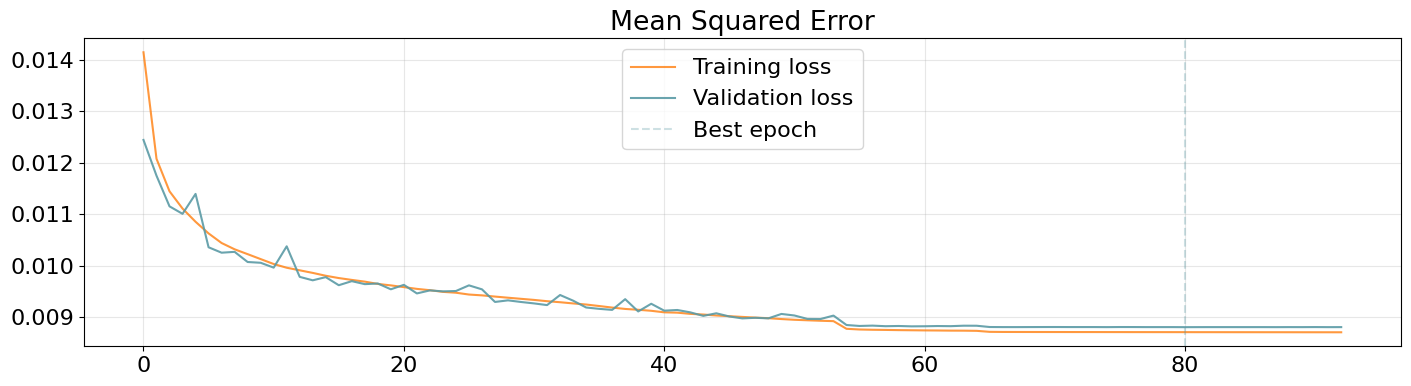

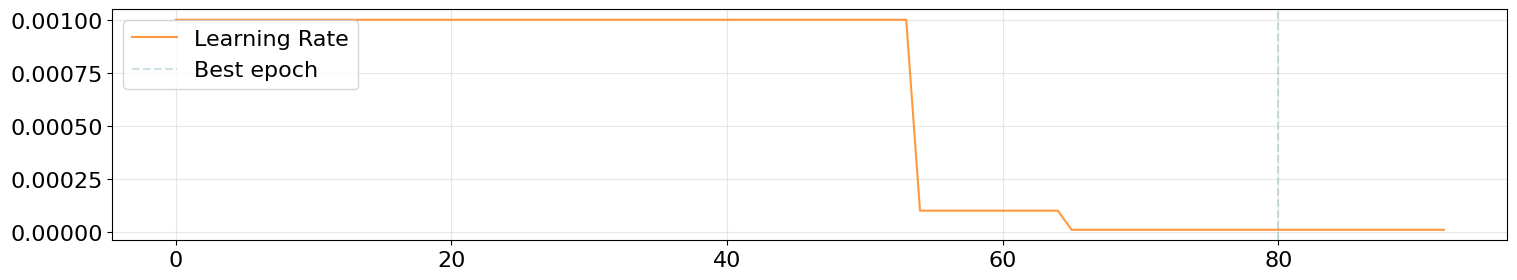

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# Predict the test set using the model
predictions = model.predict(X_val, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_val.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_val.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (31611, 18, 1)
Mean Squared Error: 0.00913008488714695
Mean Absolute Error: 0.06221941486001015


### Plotting prediction graph

In [ ]:
model1 = tf.keras.models.load_model('test_3conv1d+2blstm')
model2 = tf.keras.models.load_model('resnet_test7')
model3 = tf.keras.models.load_model('autoencoder_test1')

5608


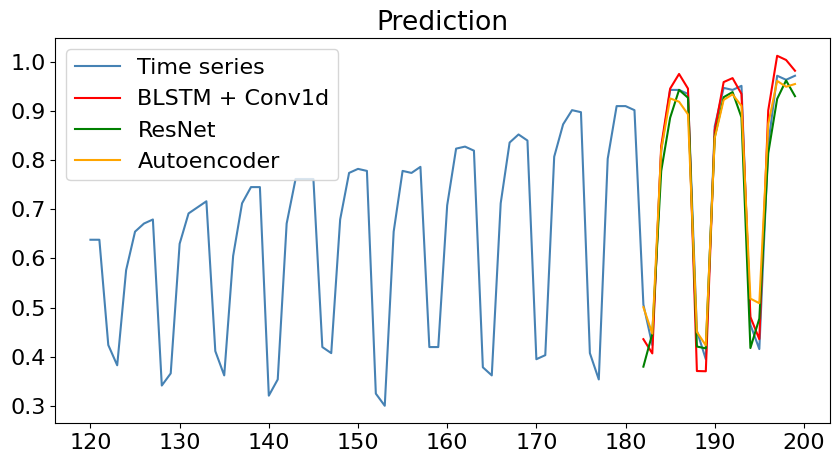

In [ ]:
#PAPER PLOTS
sel_index = random.randint(1, 31611)
print(sel_index)
rel_window_len = 200
window_to_show = 80
future_window = 18

X_test = X_val
y_test = y_val

start_w=rel_window_len-window_to_show
end_w =rel_window_len

pred_scaled1 = model1.predict(X_test, verbose=0)
pred_scaled2 = model2.predict(X_test, verbose=0)
pred_scaled3 = model3.predict(X_test, verbose=0)

pred_scaled1 = pred_scaled1[sel_index]
pred_scaled2 = pred_scaled2[sel_index]
pred_scaled3 = pred_scaled3[sel_index]



X_mean = X_test[sel_index].mean(axis=0)
X_std = X_test[sel_index].std(axis=0)

X = np.concatenate((X_test[sel_index],y_test[sel_index]), axis=0)
plt.figure(figsize=(10,5))
plt.plot(range(start_w,end_w),X[-window_to_show:],color='steelblue',label='Time series')

plt.plot(range(end_w-future_window,end_w),pred_scaled1[:future_window],color='red',label='BLSTM + Conv1d')
plt.plot(range(end_w-future_window,end_w),pred_scaled2[:future_window],color='green',label='ResNet')
plt.plot(range(end_w-future_window,end_w),pred_scaled3[:future_window],color='orange',label='Autoencoder')

plt.title('Prediction')
plt.legend()
plt.savefig('tinyplot')